In [1]:
!pip install pandas

In [2]:
!pip install numpy

In [3]:
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [5]:
# Load dataset
df = pd.read_csv("AirQualityUCI.csv", sep = ";", decimal=',')

print(df.shape)
df.head()

# Clean input table
df = df.drop(columns=["Unnamed: 15", "Unnamed: 16"])
df.head()

# Check missing NA
missing_counts = df.isna().sum()
print(missing_counts)

print(df.isna())

# Remove NAs
df = df.dropna()

missing_counts = df.isna().sum()
print(missing_counts)

# Total records
total_records = df.shape[0]
print(f"Total records: {total_records}")

# Check missing values
missing_counts = (df == -200).sum()
print(missing_counts)

# Transform missing values -200 to NAs
df.replace(-200, pd.NA, inplace=True)
missing_counts = df.isna().sum()
print(missing_counts)

# Handle missing values
# For few missing data -> remove the records
df = df.dropna(subset=['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'])
missing_counts = df.isna().sum()
print(missing_counts)

# Total records
total_records = df.shape[0]
print(f"Total records: {total_records}")

# Handle missing values
# Replace missing values with mean
for column in ['CO(GT)', 'NOx(GT)', 'NO2(GT)']:
    df[column] = df[column].fillna(df[column].mean())
missing_counts = df.isna().sum()
print(missing_counts)

# Total records
total_records = df.shape[0]
print(f"Total records: {total_records}")

# Handle missing values
# Drop the column
df = df.drop(columns=['NMHC(GT)'])
missing_counts = df.isna().sum()
print(missing_counts)

(9471, 17)
Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64
       Date   Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
0     False  False   False        False     False     False          False   
1     False  False   False        False     False     False          False   
2     False  False   False        False     False     False          False   
3     False  False   False        False     False     False          False   
4     False  False   False        False     False     False          False   
...     ...    ...     ...          ...       ...       ...            ...   
9466   True   True    True         True      True      True           True   
9467   True   True    True         Tr

<ipython-input-5-fd457bf0499f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(-200, pd.NA, inplace=True)
<ipython-input-5-fd457bf0499f>:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].fillna(df[column].mean())


In [6]:
# Format date
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].str.replace('.', ':'), format='%d/%m/%Y %H:%M:%S')

Linear Regression - MSE: 1.90, MAE: 1.16
Random Forest - MSE: 1.68, MAE: 1.00


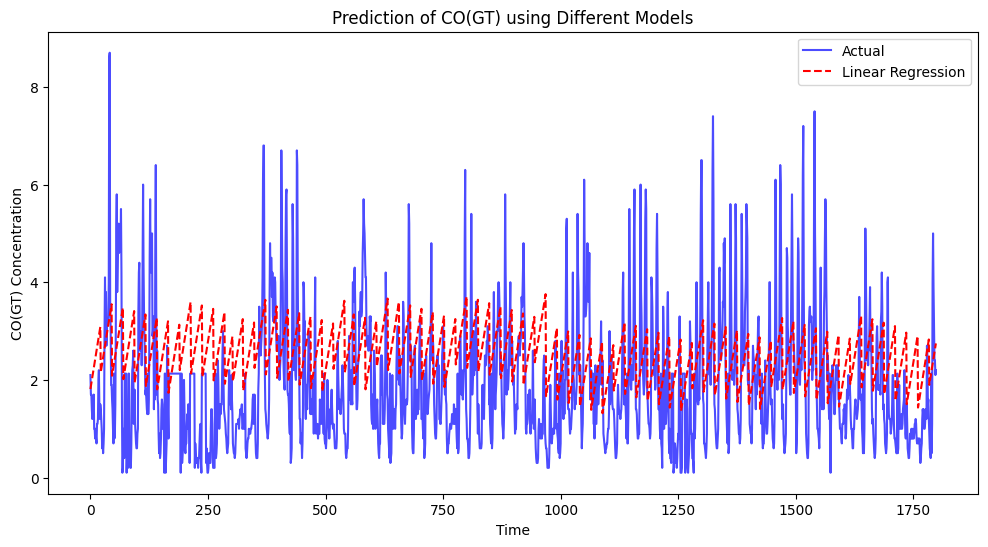

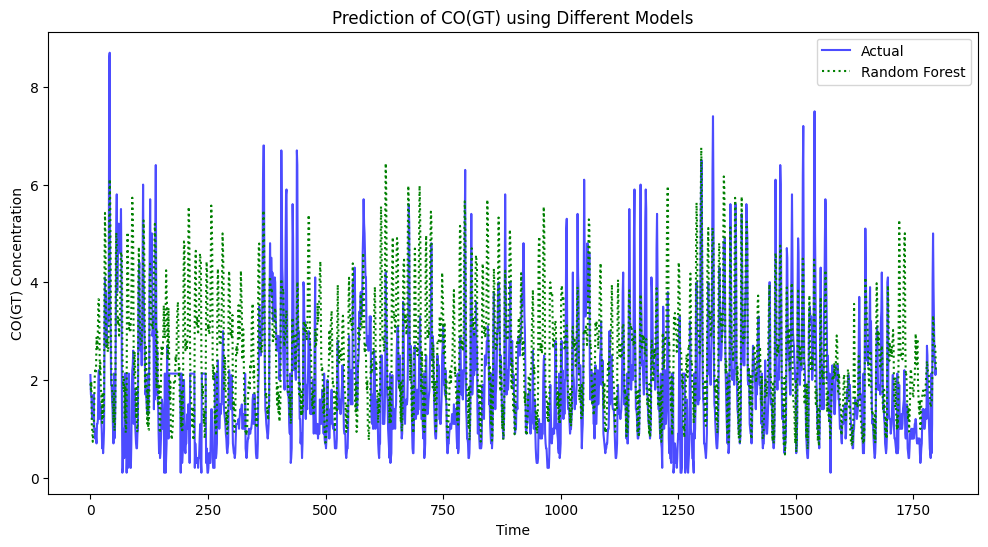

Linear Regression - MSE: 27612.65, MAE: 116.51
Random Forest - MSE: 4867.19, MAE: 42.89


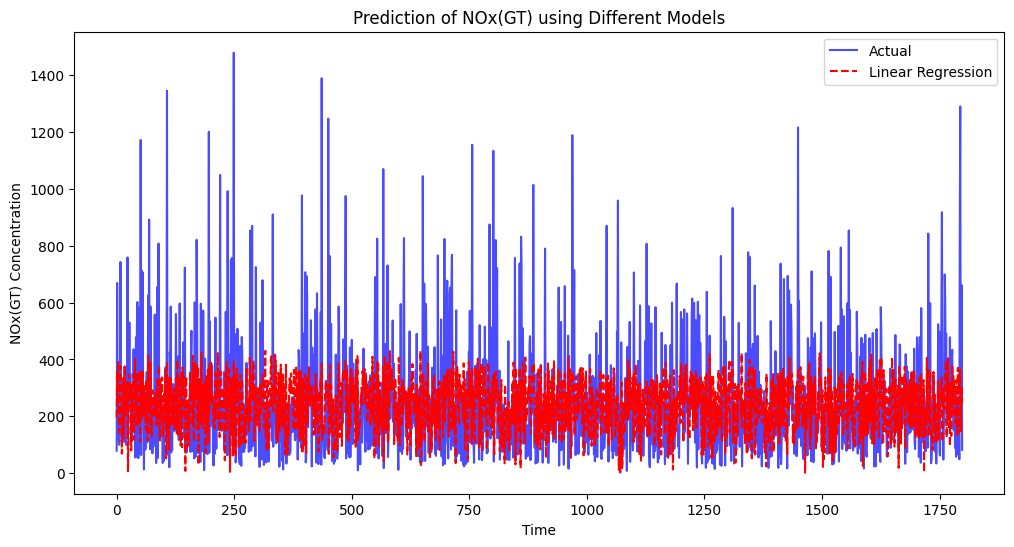

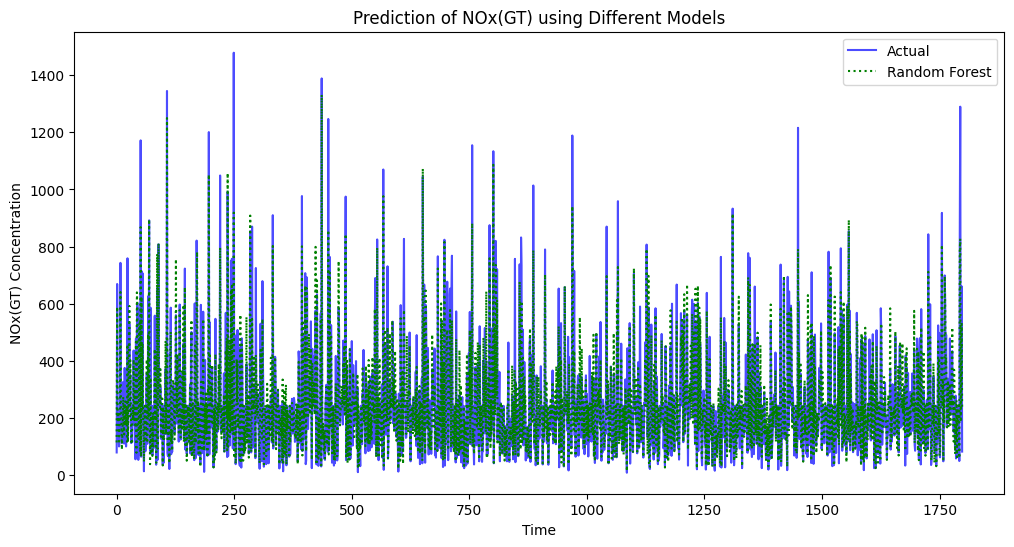

Linear Regression - MSE: 48.70, MAE: 5.22
Random Forest - MSE: 10.64, MAE: 2.20


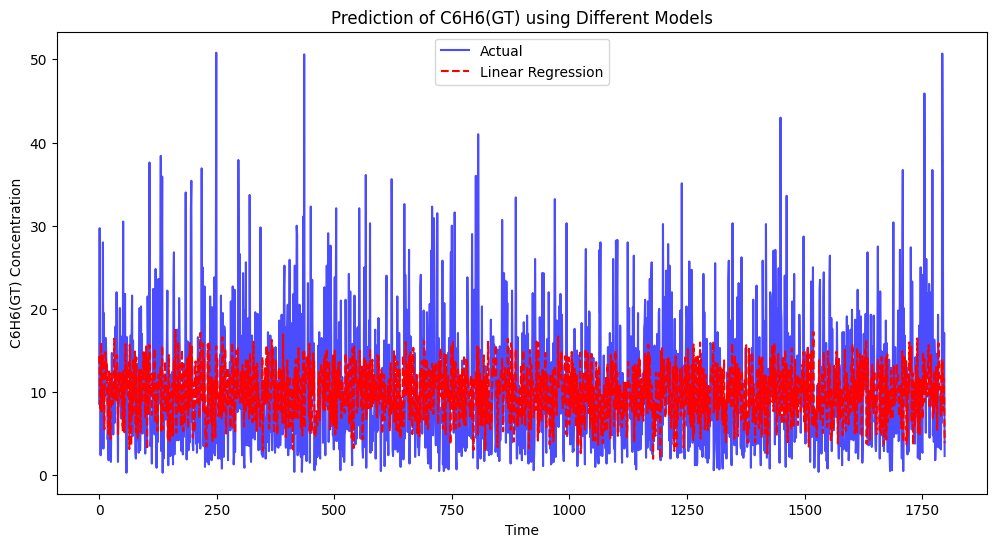

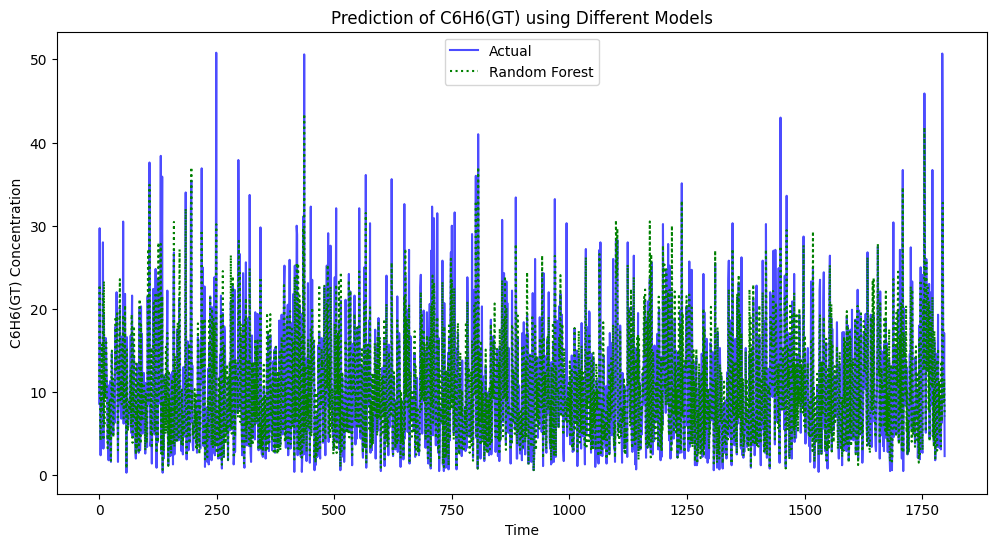

In [18]:
# Model prediction
# Extract time-based features
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['hour'] = df['DateTime'].dt.hour

# Fit model for CO
target_pollutant = 'CO(GT)'
features = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour']

X = df[features]
y = df[target_pollutant]

# Split Data
# Sort by DateTime to ensure chronological order
df = df.sort_values('DateTime')

# Extract features and target
X = df[features]
y = df[target_pollutant]

# Chronological split (e.g., last 20% of data for testing)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train and Evaluate Models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return y_pred

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", linestyle="dotted", color="green")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

# Fit model for NOx
target_pollutant = 'NOx(GT)'
features = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour']

X = df[features]
y = df[target_pollutant]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return y_pred

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", linestyle="dotted", color="green")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

# Fit model for Benzene
target_pollutant = 'C6H6(GT)'
features = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour']

X = df[features]
y = df[target_pollutant]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return y_pred

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", linestyle="dotted", color="green")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

<ipython-input-19-0433856a2ef9>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Linear Regression - MSE: 0.00, MAE: 0.00
Random Forest - MSE: 0.07, MAE: 0.15


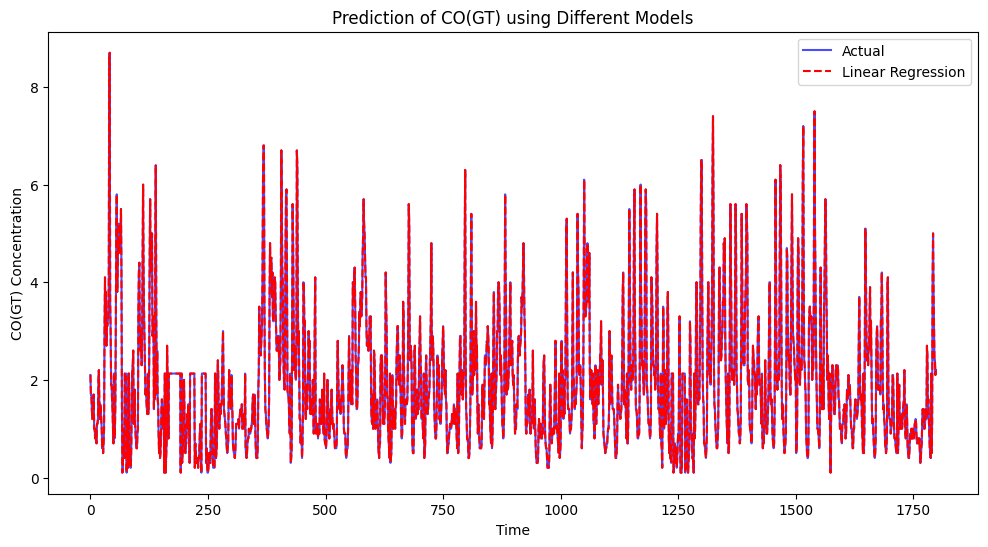

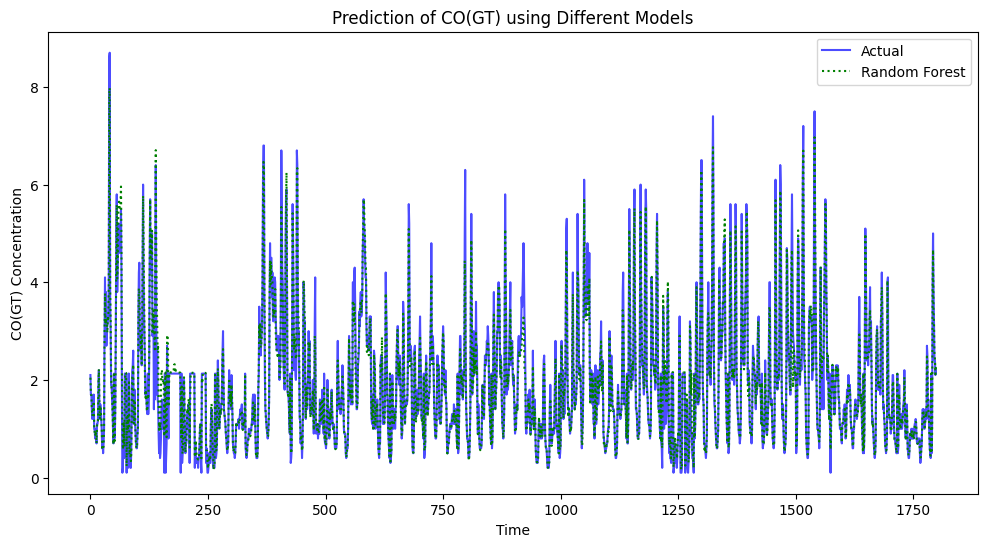

Linear Regression - MSE: 6909.13, MAE: 60.48
Random Forest - MSE: 2284.46, MAE: 25.12


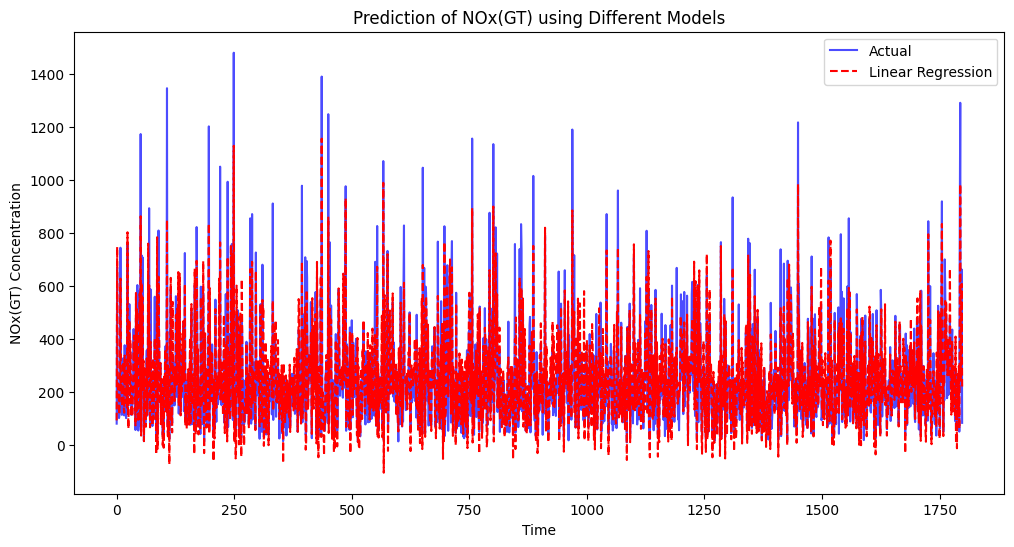

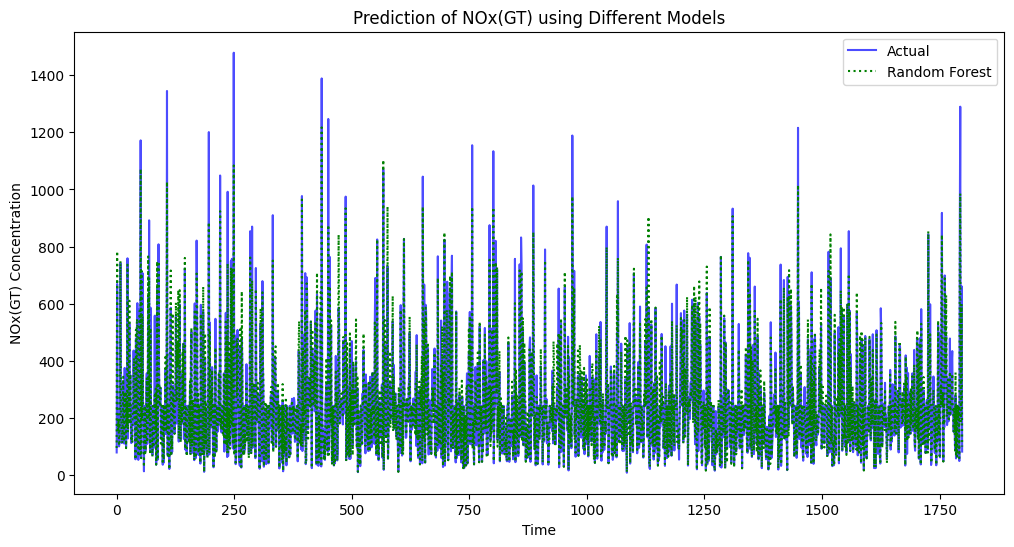

Linear Regression - MSE: 15.11, MAE: 2.52
Random Forest - MSE: 4.80, MAE: 1.40


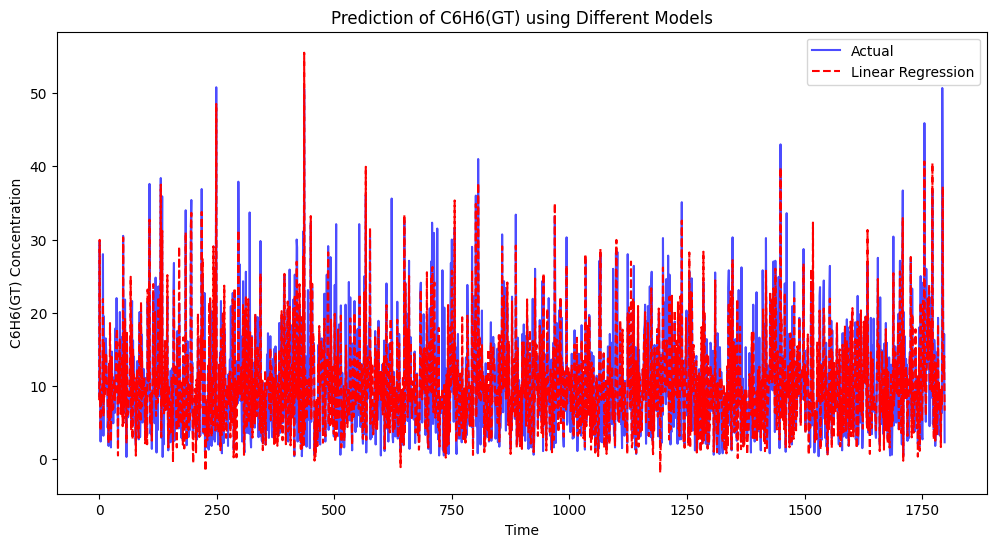

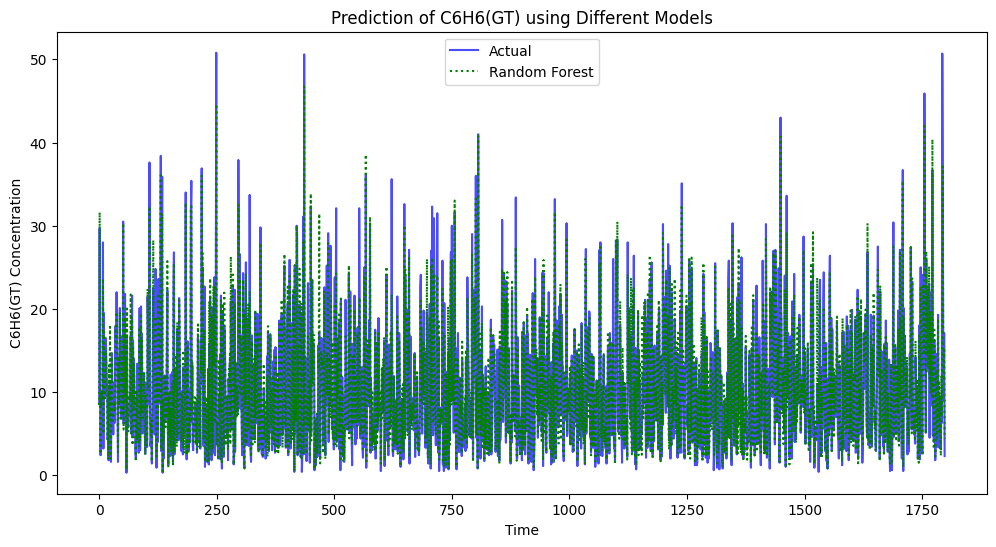

In [19]:
# Model prediction

# Feature engineering
# Extract time-based features
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['hour'] = df['DateTime'].dt.hour

# Creating lag features for CO, NOx, and Benzene
for lag in [1, 2, 3, 6, 12, 24]:
    df[f"CO_lag_{lag}"] = df["CO(GT)"].shift(lag)
    df[f"NOx_lag_{lag}"] = df["NOx(GT)"].shift(lag)
    df[f"Benzene_lag_{lag}"] = df["C6H6(GT)"].shift(lag)

# Creating rolling statistics (rolling mean and std deviation)
for window in [3, 6, 12]:
    df[f"CO_roll_mean_{window}"] = df["CO(GT)"].rolling(window=window).mean()
    df[f"CO_roll_std_{window}"] = df["CO(GT)"].rolling(window=window).std()
    df[f"NOx_roll_mean_{window}"] = df["NOx(GT)"].rolling(window=window).mean()
    df[f"NOx_roll_std_{window}"] = df["NOx(GT)"].rolling(window=window).std()
    df[f"Benzene_roll_mean_{window}"] = df["C6H6(GT)"].rolling(window=window).mean()
    df[f"Benzene_roll_std_{window}"] = df["C6H6(GT)"].rolling(window=window).std()

df.fillna(method='bfill', inplace=True)

# Fit model for CO
target_pollutant = 'CO(GT)'
#features = [col for col in df.columns if col != target_pollutant]
features = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour', 'CO_lag_1', 'CO_lag_2', 'CO_lag_3', 'CO_lag_6', 'CO_lag_12', 'CO_lag_24', 'CO_roll_mean_3', 'CO_roll_mean_6', 'CO_roll_mean_12', 'CO_roll_std_3', 'CO_roll_std_6', 'CO_roll_std_12', 'NOx(GT)', 'C6H6(GT)']
X = df[features]
y = df[target_pollutant]

# Split Data
# Sort by DateTime to ensure chronological order
df = df.sort_values('DateTime')

# Extract features and target
X = df[features]
y = df[target_pollutant]

# Chronological split (e.g., last 20% of data for testing)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train and Evaluate Models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return y_pred

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", linestyle="dotted", color="green")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

# Fit model for NOx
target_pollutant = 'NOx(GT)'
#features = [col for col in df.columns if col != target_pollutant]
features = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour', 'CO_lag_1', 'CO_lag_2', 'CO_lag_3', 'CO_lag_6', 'CO_lag_12', 'CO_lag_24', 'CO_roll_mean_3', 'CO_roll_mean_6', 'CO_roll_mean_12', 'CO_roll_std_3', 'CO_roll_std_6', 'CO_roll_std_12', 'CO(GT)', 'NO2(GT)']
X = df[features]
y = df[target_pollutant]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return y_pred

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", linestyle="dotted", color="green")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

# Fit model for Benzene
target_pollutant = 'C6H6(GT)'
#features = [col for col in df.columns if col != target_pollutant]
features = ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour', 'CO_lag_1', 'CO_lag_2', 'CO_lag_3', 'CO_lag_6', 'CO_lag_12', 'CO_lag_24', 'CO_roll_mean_3', 'CO_roll_mean_6', 'CO_roll_mean_12', 'CO_roll_std_3', 'CO_roll_std_6', 'CO_roll_std_12', 'CO(GT)']
X = df[features]
y = df[target_pollutant]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Models

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return y_pred

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest", linestyle="dotted", color="green")
plt.legend()
plt.title(f"Prediction of {target_pollutant} using Different Models")
plt.xlabel("Time")
plt.ylabel(f"{target_pollutant} Concentration")
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

SARIMA - MSE: 2.93, MAE: 1.43


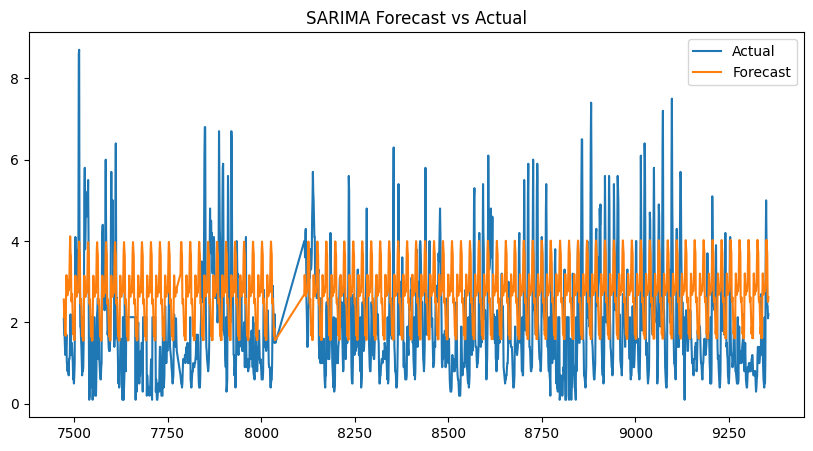

In [9]:
# Assuming `df` is your preprocessed DataFrame and datetime is the index
ts_co = df['CO(GT)'].replace(-200, np.nan).dropna()

# Train-test split (80-20 chronological)
train_size = int(len(ts_co) * 0.8)
train, test = ts_co[:train_size], ts_co[train_size:]

# Fit SARIMA model
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,24))
sarima_result = model.fit(disp=False)

# Forecast
forecast = sarima_result.forecast(steps=len(test))

# Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"SARIMA - MSE: {mse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

SARIMA - MSE: 80984.81, MAE: 244.84


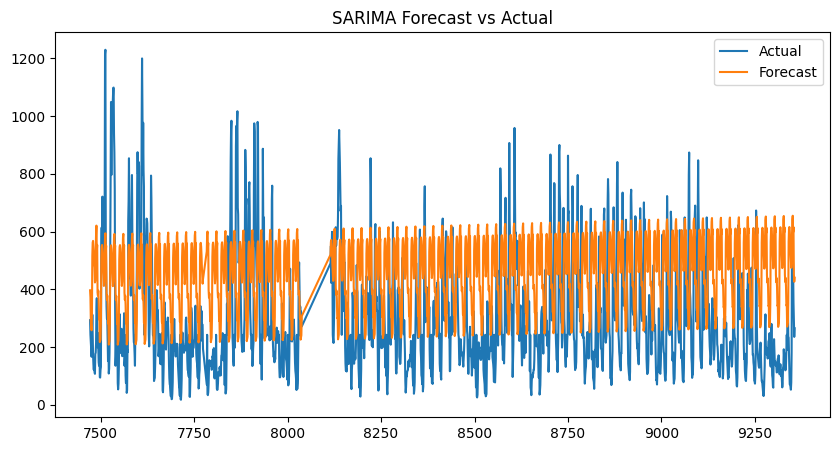

In [10]:
# Assuming `df` is your preprocessed DataFrame and datetime is the index
ts_co = df['NOx(GT)'].replace(-200, np.nan).dropna()

# Train-test split (80-20 chronological)
train_size = int(len(ts_co) * 0.8)
train, test = ts_co[:train_size], ts_co[train_size:]

# Fit SARIMA model
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,24))
sarima_result = model.fit(disp=False)

# Forecast
forecast = sarima_result.forecast(steps=len(test))

# Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"SARIMA - MSE: {mse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

SARIMA - MSE: 73.99, MAE: 7.23


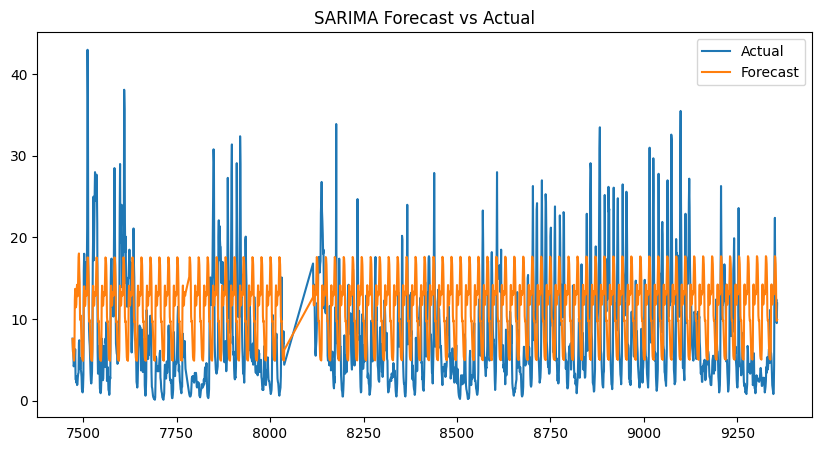

In [11]:
# Assuming `df` is your preprocessed DataFrame and datetime is the index
ts_co = df['C6H6(GT)'].replace(-200, np.nan).dropna()

# Train-test split (80-20 chronological)
train_size = int(len(ts_co) * 0.8)
train, test = ts_co[:train_size], ts_co[train_size:]

# Fit SARIMA model
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,24))
sarima_result = model.fit(disp=False)

# Forecast
forecast = sarima_result.forecast(steps=len(test))

# Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f"SARIMA - MSE: {mse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0145 - val_loss: 0.0065
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0039 - val_loss: 0.0041
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM - MSE: 0.54, MAE: 0.50


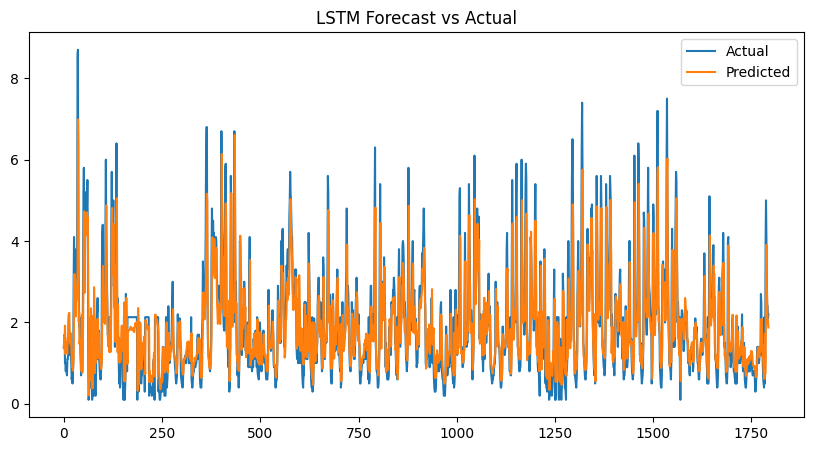

In [12]:
# Prepare time series
data = df['CO(GT)'].replace(-200, np.nan).dropna().values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 24
X, y = create_sequences(scaled_data, TIME_STEPS)

# Split data
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(TIME_STEPS, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluation
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"LSTM - MSE: {mse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0031 - val_loss: 0.0054
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM - MSE: 11105.12, MAE: 70.77


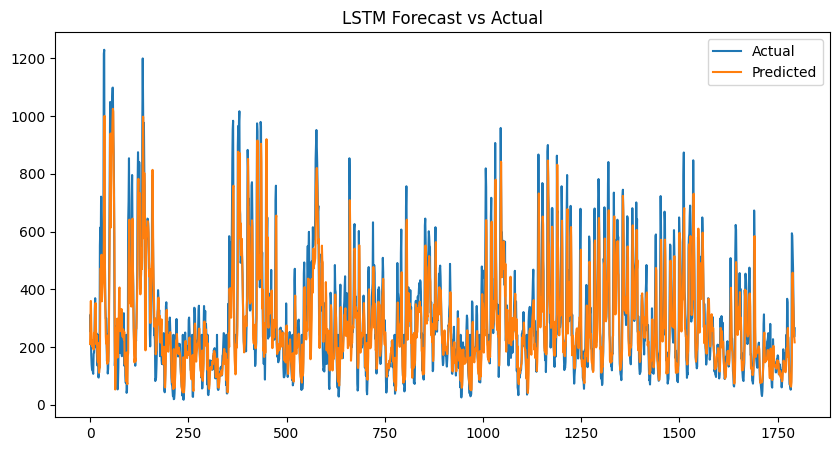

In [13]:
# Prepare time series
data = df['NOx(GT)'].replace(-200, np.nan).dropna().values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 24
X, y = create_sequences(scaled_data, TIME_STEPS)

# Split data
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(TIME_STEPS, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluation
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"LSTM - MSE: {mse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0131 - val_loss: 0.0046
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0034 - val_loss: 0.0026
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM - MSE: 9.60, MAE: 2.06


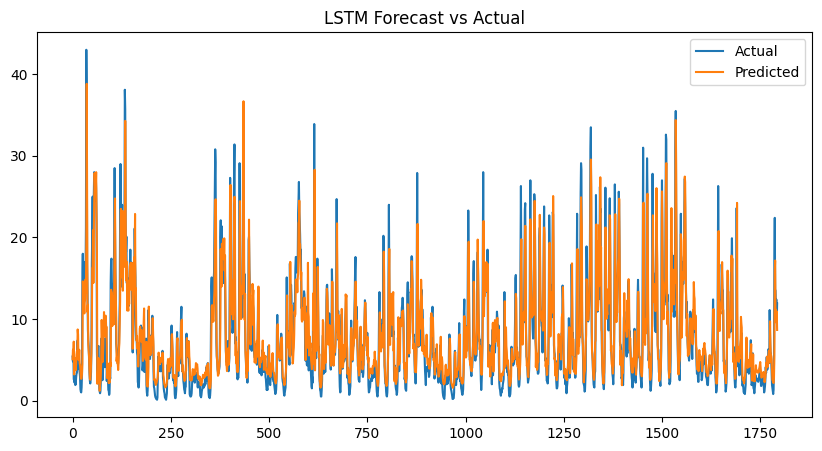

In [14]:
# Prepare time series
data = df['C6H6(GT)'].replace(-200, np.nan).dropna().values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 24
X, y = create_sequences(scaled_data, TIME_STEPS)

# Split data
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(TIME_STEPS, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluation
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"LSTM - MSE: {mse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()